In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import tensorflow as tf
import lucid
import atari_zoo
from atari_zoo import MakeAtariModel

from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.transform as transform
import lucid.optvis.render as render

from atari_zoo import synthetic_inputs

/home/joel.lehman/code/rl_base/env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [1]:
#tf.get_default_session().close()

## High-level interface to optimize inputs to maximize activation of particular channels / FC neurons

In [ ]:
import atari_zoo.synthetic_inputs
from atari_zoo.synthetic_inputs import make_regularization,visualize_neuron,cppn_default_f
from lucid.misc.io.showing import images

### Example: lane features in Rainbow Freeway network

In [ ]:
algorithm = 'rainbow'
env='FreewayNoFrameskip-v4'
run_id = 1
tag='final'

out = visualize_neuron(algo=algorithm,env=env,run_id=run_id,tag=tag,layer_no=3,neuron=1,step_n=1024,regularization=make_regularization(L1=1e-8,TV=1e-8))


images(out[0].transpose((2,0,1)))

### Same neuron, visualized through a CPPN (ala "Differentiable Image Parameterizations" on distill.pub)

In [20]:
out = visualize_neuron(algo=algorithm,env=env,run_id=run_id,tag=tag,layer_no=3,neuron=1,step_n=1024,param_f=cppn_default_f,lr=0.001)

Model path: gs://download-dopamine-rl/lucid/rainbow/Freeway/1/graph_def.pb



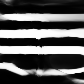
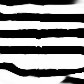
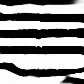
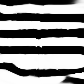

In [21]:
images(out[0].transpose((2,0,1)))

## More manual approach to integrating with Lucid (more flexibility but more verbose code)

Model path: gs://download-dopamine-rl/lucid/rainbow/Freeway/1/graph_def.pb
Data path: https://dgqeqexrlnkvd.cloudfront.net/zoo/rainbow/FreewayNoFrameskip-v4/model1_final_rollout.npz
Log path: https://dgqeqexrlnkvd.cloudfront.net/zoo/rainbow/checkpoints/FreewayNoFrameskip-v4_1


<Figure size 432x288 with 0 Axes>

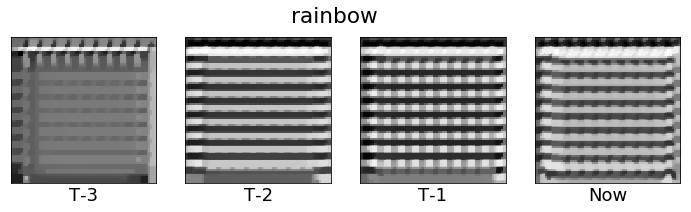

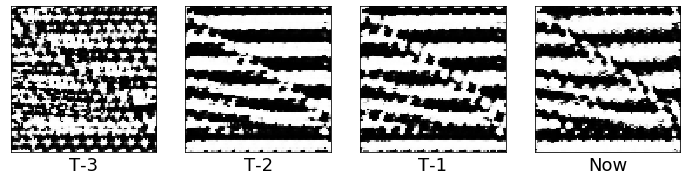

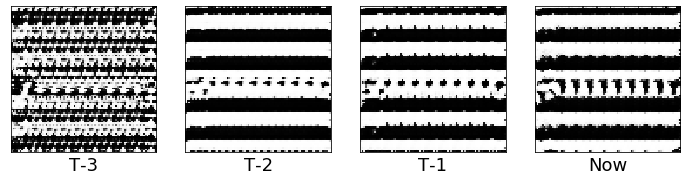

In [12]:
import gym
import pylab
from lucid.optvis.objectives import wrap_objective, Objective
import matplotlib

env = "FreewayNoFrameskip-v4"
algo = 'rainbow'
run_id=1

#alternative parameterization that only optimizes the "now" frame
def only_current_frame(shape):
    shape_1 = shape[:-1]+[1,]
    
    shape_2 = shape[:]
    shape_2[-1] -= 1
    
    print(shape_1,shape_2)
    
    current_frame = lucid.optvis.param.spatial.naive(shape_1)
    zero_frames = tf.zeros(shape_2)
       
    processed_current = tf.nn.sigmoid(current_frame)
    processed_frames = tf.concat([zero_frames,processed_current],-1)
    return processed_frames

#param = lambda: only_current_frame([1,84,84,4])
param = lambda: synthetic_inputs.image([1,84,84,4])


tf.reset_default_graph()
m = MakeAtariModel(algo,env,run_id,local=False)()
m.load_graphdef()

transforms = [
    transform.jitter(2),
]

pylab.gray()

regularize = 1e-9*objectives.L2()-1e-9*objectives.L1()-1e-8*objectives.total_variation()

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

#loop through all available actions in the game
for neuron in range(0,3): #len(action_semantics)):
    obj = objectives.channel(m.layers[-3]['name'],neuron)

    #call out to lucid
    out = render.render_vis(m, obj+regularize,
                            param_f = param,
                        transforms=transforms,verbose=False,thresholds=(512,))
    
    #now let's visualize the results...
    frames = len(out)
    fig = pylab.figure(figsize=(12,3))
    
    if neuron==0:
            fig.suptitle(algo) #action_semantics[action],fontsize=16)
    else:
            fig.suptitle("")

    for y in range(frames):
        

        for x in range(4):
            num = (y*4+x)+1
            ax=pylab.subplot(frames,4,num)
            fig = pylab.imshow(out[y][0,:,:,x])
            fig.axes.get_yaxis().set_visible(False)
            ax.set_xticks([], [])
            
            if x<3:
                title="T-%d" % (3-x)
            else:
                title="Now"
                
            size = fig.get_size() # get fig size in pixels
            ax.set_xlabel(title)
            im = out[y][0,:,:,x]
            

# Feature inversions / caricatures

In the spirit of https://distill.pub/2018/building-blocks/

In [17]:
import atari_zoo
import pylab

algo = 'a2c'
env = 'SeaquestNoFrameskip-v4'
run_id = 2

#do simple output neuron visualization (Q-value of action X)
tf.reset_default_graph()

session = atari_zoo.utils.get_session()

m = MakeAtariModel(algo,env,run_id,local=False)()
#load in model
m.load_graphdef()
m.import_graph()

#print(session.graph.get_operations())

Model path: https://dgqeqexrlnkvd.cloudfront.net/zoo/a2c/SeaquestNoFrameskip-v4/model2_final.pb
Data path: https://dgqeqexrlnkvd.cloudfront.net/zoo/a2c/SeaquestNoFrameskip-v4/model2_final_rollout.npz
Log path: https://dgqeqexrlnkvd.cloudfront.net/zoo/a2c/checkpoints/SeaquestNoFrameskip-v4_2


In [18]:
observations = m.get_observations()
frames = m.get_frames()
frames_float = frames / 255.

In [19]:
transforms = [
    transform.jitter(2),
    #transform.random_scale([n/100. for n in range(80, 120)]),
    #transform.random_rotate([n/1. for n in range(-5,5)]) # + range(-5,5) + 10*range(-2,2)),
]

pylab.gray()

#feature inversion objective
@objectives.wrap_objective
def dot_compare(layer, batch=1, cossim_pow=0):
  def inner(T):
    dot = tf.reduce_sum(T(layer)[batch] * T(layer)[0])
    mag = tf.sqrt(tf.reduce_sum(T(layer)[0]**2))
    cossim = dot / (1e-6 + mag)
    cossim = tf.maximum(0.1, cossim)
    return dot * cossim ** cossim_pow
  return inner

<Figure size 432x288 with 0 Axes>

frames



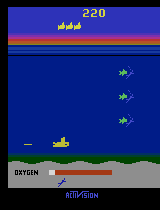
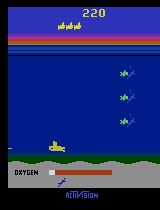
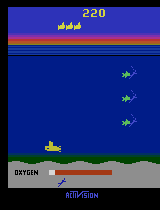
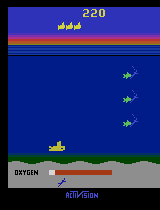

pre-processed frames



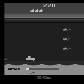
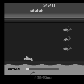
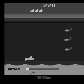
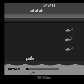

a2c/conv1/Relu



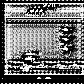
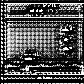
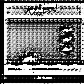
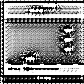

a2c/conv2/Relu



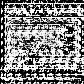
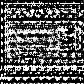
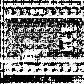
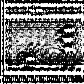

a2c/conv3/Relu



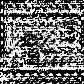
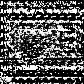
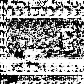
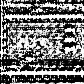

In [20]:
timestep = 500
import numpy as np
from lucid.misc.io import load, save, show
from lucid.misc.io.showing import images
# show original frames
print("frames")
show(frames_float[timestep-4:timestep])

# show observations
print("pre-processed frames")
img = observations[timestep]
images(np.transpose(img, (2,0,1)))

# show caricatures
for layer in m.layers[:-2]:
  layer_name = layer['name']
  print(layer_name)
  
  with tf.Graph().as_default(), tf.Session() as sess:

    objective = dot_compare(layer_name, cossim_pow=1.0)

    t_input = tf.placeholder(tf.float32, img.shape)
    param_f = synthetic_inputs.image([1,84,84,4])
    param_f = tf.stack([param_f[0], t_input])

    transforms = [
      transform.pad(2, mode='constant', constant_value=.5),
      transform.jitter(2),
      #transform.jitter(0),
    ]

    T = render.make_vis_T(m, objective, param_f, transforms=transforms)
    loss, vis_op, t_image = T("loss"), T("vis_op"), T("input")

    tf.global_variables_initializer().run()
    for i in range(512): _ = sess.run([vis_op], {t_input: img})

    result = t_image.eval(feed_dict={t_input: img})[0]
    images(np.transpose(result, (2,0,1)))

This gives a sense of what information DNNs are preserving as networks get deeper

## Look at particular neuron

In [4]:
import tensorflow as tf
import gym
import pylab
import lucid
import atari_zoo
from atari_zoo import MakeAtariModel

def dope_image(shape, add_noise=False):
  if add_noise:
    raw_frames = lucid.optvis.param.spatial.naive(shape, sd=0.5)
  else:
    raw_frames = lucid.optvis.param.spatial.naive(shape)
  processed_frames = tf.nn.sigmoid(raw_frames)
  return processed_frames

#do simple output neuron visualization (Q-value of action X)
tf.reset_default_graph()
algo = 'apex'
env = 'SeaquestNoFrameskip-v4'
run_id = 2
m = MakeAtariModel(algo,env,run_id,local=False)()
#load in model
m.load_graphdef()
#m.import_graph()


Model path: https://dgqeqexrlnkvd.cloudfront.net/zoo/apex/SeaquestNoFrameskip-v4/model2_final.pb
Data path: https://dgqeqexrlnkvd.cloudfront.net/zoo/apex/SeaquestNoFrameskip-v4/model2_final_rollout.npz
Log path: https://dgqeqexrlnkvd.cloudfront.net/zoo/apex/checkpoints/SeaquestNoFrameskip-v4_2


deepq/q_func/convnet/Conv_2/Relu
1024 [0.00784419]
01: Direction_Cossim [..., ..., NHWC]:    0.01



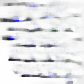

0.00583659 0.11390039
0.005510316 0.4873783
0.0033509536 0.9695292
0.0023913395 0.94546115


<Figure size 432x288 with 0 Axes>

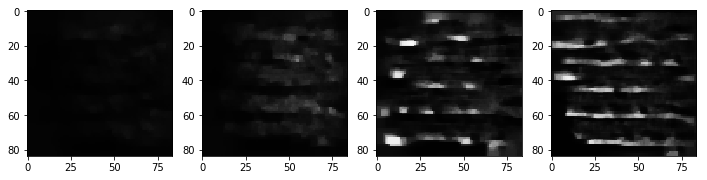

In [5]:
from lucid.optvis.objectives import wrap_objective, Objective
import numpy as np

#create a lucid objective corresponding to advantage

@wrap_objective
def channel(layer, n_channel, ordering="NHWC"):
  """Tensor-order aware version of channel lucid objective"""
  if ordering=='NCHW':
    return lambda T: tf.reduce_mean(tf.transpose(T(layer),perm=[0,2,3,1])[...,n_channel])
  else:
    return lambda T: tf.reduce_mean(T(layer)[..., n_channel])

@wrap_objective
def L2c(layer="input", constant=0, epsilon=1e-6, batch=None,channel=0):
  """L2 norm of layer. Generally used as penalty."""
  if batch is None:
    return lambda T: tf.sqrt(epsilon + tf.reduce_sum((T(layer)[...,channel] - constant) ** 2))
  else:
    return lambda T: tf.sqrt(epsilon + tf.reduce_sum((T(layer)[batch,...,channel] - constant) ** 2))

@wrap_objective
def direction_cossim(layer, vec, ordering="NHWC"):
  """Visualize a direction (cossine similarity)"""
  def inner(T):
    if ordering=='NCHW':
        _layer = T(layer)
    else:
        _layer = tf.transpose(T(layer),perm=[0,2,3,1])
        
    act_mags = tf.sqrt(tf.reduce_sum(_layer**2, -1, keepdims=True))
    vec_mag = tf.sqrt(tf.reduce_sum(vec**2))
    
    mags = act_mags * vec_mag
    return tf.reduce_mean(_layer * vec.reshape([1, 1, 1, -1]) / mags)
    
  return inner

@wrap_objective
def direction_neuroncossim(layer, vec, ordering="NHWC"):
  """Visualize a direction (cossine similarity)"""
  def inner(T):
    if ordering=='NCHW':
        _layer = T(layer)
    else:
        _layer = tf.transpose(T(layer),perm=[0,2,3,1])
        
    act_mags = tf.sqrt(tf.reduce_sum(_layer[:,5:6,5:6,:]**2, -1, keepdims=True))
    vec_mag = tf.sqrt(tf.reduce_sum(vec**2))
    
    mags = act_mags * vec_mag
    return tf.reduce_mean(_layer[:,5:6,5:6,:] * vec.reshape([1, 1, 1, -1]) / mags)
    
  return inner


transforms = [
    transform.jitter(10),
    #transform.random_scale([n/100. for n in range(80, 120)]),
    #transform.random_rotate([n/1. for n in range(-5,5)]) # + range(-5,5) + 10*range(-2,2)),
]

pylab.gray()

layer_idx = -3
layer_name = m.layers[layer_idx]['name']

print(layer_name)

obj = channel(layer_name,60,m.channel_order)
regularize =-0.0005*objectives.L1()-0.0002*objectives.total_variation()

vec = np.zeros(64,dtype=np.float32)
vec[60]=1.0
#obj = direction_cossim(layer_name,vec)
regularize =-0.000001*objectives.L1()-0.0000001*objectives.total_variation()

obj = direction_cossim(layer_name,vec)
regularize = -1e-6*objectives.total_variation()-1e-9*objectives.L2()-5e-7*objectives.L1()

#regularize=0

#regularize = -0.0003*objectives.L2()-0.125*L2c(channel=2)-0.0005*objectives.L1()-0.0005*objectives.total_variation()

#param = lambda: only_current_frame([1,84,84,4])
param = lambda: dope_image([1,84,84,4])

out = render.render_vis(m, regularize + obj,
                            param_f = param,
                        transforms=transforms,verbose=True,thresholds=(1024,),
                       print_objectives=[obj])
    
#now let's visualize the results...
fig = pylab.figure(figsize=(12,3))
frames = len(out)
y=0
for x in range(4):
            num = (y*4+x)+1
            pylab.subplot(frames,4,num)
            val = out[y][0,:,:,x]
            print(val.min(),val.max())
            pylab.imshow(out[y][0,:,:,x],vmin=0.0,vmax=1.0)


<Figure size 432x288 with 0 Axes>

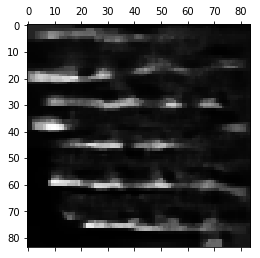

In [6]:
pylab.figure()
pylab.matshow(out[y][0,:,:,3])
from lucid.misc.io import show, save, load
save(out[0],"output.npy")

## Validating that optimized image has desired effect (i.e. does actually activate a particular feature map)

In [7]:
import atari_zoo.utils
import numpy as np
out_img = np.load("output.npy")

algo = 'apex'
m = MakeAtariModel(algo,env,run_id,local=False)()
m.load_graphdef()
#import importlib
#importlib.reload(atari_zoo.utils)
from atari_zoo.utils import conv_activations_to_canvas
from atari_zoo.utils import fc_activations_to_canvas

from lucid.optvis.render import import_model

#get a tf session
session = atari_zoo.utils.get_session()

#create a placeholder input to the network
X_t = tf.placeholder(tf.float32, [None] + m.image_shape)

#now get access to a dictionary that grabs output layers from the model
T = import_model(m,X_t,X_t)

#print(session.graph.get_operations())

import pylab 

rep_layer = m.layers[-3]['name'] #second-to-last-layer (representation layer)
rep_layer_T = T(rep_layer)

rep = session.run(rep_layer_T,{X_t:out_img})


Model path: https://dgqeqexrlnkvd.cloudfront.net/zoo/apex/SeaquestNoFrameskip-v4/model2_final.pb
Data path: https://dgqeqexrlnkvd.cloudfront.net/zoo/apex/SeaquestNoFrameskip-v4/model2_final_rollout.npz
Log path: https://dgqeqexrlnkvd.cloudfront.net/zoo/apex/checkpoints/SeaquestNoFrameskip-v4_2


In [8]:
rep_scaled = np.clip(rep,0,3)


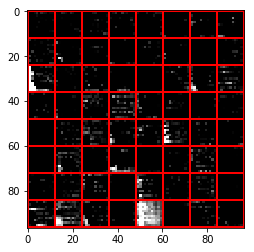

In [9]:
canvas = conv_activations_to_canvas(m,rep_scaled,padding=1)
pylab.imshow(canvas)

In [10]:
#Check particular feature map we were maximizing (in this case 60)

rep[0,60,5,5].mean()

1.8514978

(1, 64, 11, 11)


<Figure size 432x288 with 0 Axes>

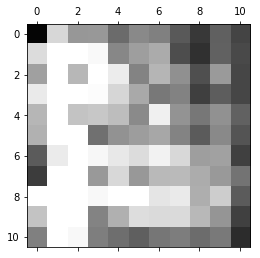

In [11]:
#Visualize that feature map

pylab.gray()
pylab.matshow(rep[0,60],vmin=0,vmax=3)
print(rep.shape)